## Really complicated dna differentiation

Imagine a chain of nucleotides, divided in genes and intragenic DNA. Genes must be functioning, so they have a pattern, intragenic DNA not, so it can be random.

...intagrenic----gene----intragenic---gene---intragenic....

GENES

We have N genes Genes have the same order among neanderthal and humans:

Hair--Height--Eyes--Beard.. <- Neanderthal Hair--Height--Eyes--Beard.. <- Human

Humans and neanderthal are similar, so they have similar genes. Hence for a sigle gene i decided to have different variants, like brown hair, blond hairs, but they have to differ for small variation otherwise you would be bald.

From a logic point of view, change a small number of nucleotides from a random sequence so you have the variants, but they keep the same lenght in all the variants.

Genes have correlations between themselves, decided randomly between a random number of genes. For example Genes 1,8,15 are correlated in humans, correlations between 3 elements-> why? 3 is sampled from a "discrete gaussian", why 1,8,15 choseen random.

INTRAGENIC

We have N+1 intragenic sequence, of variable lenght interposed between genes.

How humans differ from neanderthal??

Intragenic dna different in lenght, for example in a human intragenic dna between genes 1 and 2, contains 100 nucleotides, while in the neanderthal 90. Correlations between different genes. like neanderthal correlates Nose and Beard, while human Height and Fat percentage.

How humans differ from humans and neanderthal from neanderthal?

Same intragenic lenght, but different nucleotides. Different genes variants.


In [1]:
#import tensorflow as tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, concatenate
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import tfidTransformer

tokenizer = Tokenizer()

#import tensorflow as tensorflow
#if tensorflow.test.gpu_device_name():
#    print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
#else:
#    print("Please install GPU version of tensorflow")

In [2]:
#Manopole
#decide the percentage of geneDNA in a sentence.
pc_genes=0.75

#How many genes?
N_genes= 50

#Choose genes to correlate

#How many?
avg_dimension_of_correlation_clusters=7

b=0.5 #how different are different genes ? max 0.5
fraction_of_mutations_per_gene=0.3#percentage of random mutations in gene variants
variants=4 #how many variants?
param_mc_a= 0.5
det=(1-param_mc_a)/3 # how much deterministic is the markov chain 0 MAX 0.25 Min  shuffle(prob(det det det 1-3*det))
forward_mc = False#do you want forward markov chain? (only forward jumps)


N_people= 60000 #(N neanderthal N humans)
sentence_length= 1500 #HOW LONG A SENTENCE in letters
word_length=5 #HOW LONG A WORD in letters

#do you want same intragenic location in neanderthals and humans?
same = True

#Produce new sequences in this simulation (after creating once you can set to false)
new_chains = True


epochs = 50

## Here we characterize the lenght of each gene and intragenic subsequence

Genes char->

        Array that contains the length of each gene
        
        
Intragenic Char-(Human/Neanderthal)-> 

        Array that contains the length of each intragenic subsequence. If same = false Humans and neanderthal 
        have different Intragenic Char

In [3]:

import numpy as np
import pandas as pd


#Build Genes

genes_nucleotides = (sentence_length*pc_genes) //1 
intragenic_nucleotides= sentence_length - genes_nucleotides

print(genes_nucleotides)
print(intragenic_nucleotides)

#How many intergenic sequences?
N_intragenic=N_genes+1



def split_in_different_leghts_sequence(how_many_nucleotides_for_genes, how_many_sequences):
    N_n=how_many_nucleotides_for_genes
    N_s=how_many_sequences
    seqs=np.zeros(N_s)
    for i in range(len(seqs)-1):
        while(True):
            ls=int(np.random.poisson((N_n/N_s)))
            if ls>1: 
                break
        N_n=N_n-ls
        N_s=N_s-1
        seqs[i]=int(ls)
    seqs[-1]=N_n
    return(seqs)


genes_char=split_in_different_leghts_sequence(genes_nucleotides, N_genes)
intragenic_char_humans=split_in_different_leghts_sequence(intragenic_nucleotides, N_intragenic)
if same == False : 
    intragenic_char_neanderthal=split_in_different_leghts_sequence(intragenic_nucleotides, N_intragenic)
else :
    intragenic_char_neanderthal=intragenic_char_humans

#print how long are the genes and the intragenc
print(intragenic_char_neanderthal)
print(intragenic_char_humans)
print(genes_char)

#Now I have the characterization of all genic and intragenic sequences


1125.0
375.0
[ 8. 11.  5.  5.  9.  6.  7.  5. 11.  6.  9. 11.  2.  5.  8.  7.  9. 12.
  8. 10.  7.  7.  7.  8. 12.  7.  5. 10.  6.  8. 10.  6.  4.  4.  9.  7.
  6.  8.  2.  3.  6.  5.  3.  9. 11.  7. 12.  7. 11.  6.  8.]
[ 8. 11.  5.  5.  9.  6.  7.  5. 11.  6.  9. 11.  2.  5.  8.  7.  9. 12.
  8. 10.  7.  7.  7.  8. 12.  7.  5. 10.  6.  8. 10.  6.  4.  4.  9.  7.
  6.  8.  2.  3.  6.  5.  3.  9. 11.  7. 12.  7. 11.  6.  8.]
[19. 12. 26. 22. 28. 29. 20. 28. 23. 29. 27. 31. 19. 11. 24. 25. 18. 27.
 12. 22. 32. 24. 26. 18. 17. 20. 23. 23. 26. 23. 25. 18. 26. 21. 17. 22.
 24. 26. 15. 19. 30. 20. 17. 22. 26. 20. 35. 21. 22. 15.]


## Compute Correlation Clusters

The output will be a dataframe in which are stored the clusters of correlation of the genes

In [4]:


def correlate_genes(N_genes,cluster_dim):
    clusters=[]
    genes=[i for i in range((N_genes))]
    while(len(genes) != 0):
        while (True):
            if(cluster_dim>len(genes)): cluster_dim = len(genes)
            curr_cl= int(np.random.poisson((cluster_dim)))
            if curr_cl <= len(genes) and curr_cl>0: break
            else: print(curr_cl, len(genes))
        clusters.append(np.random.choice(genes, curr_cl, False))
        for c in clusters[-1]:
            genes.remove(c)
    return((clusters))
if new_chains == True:
    corrs_human=correlate_genes(N_genes,avg_dimension_of_correlation_clusters)
    corrs_neanderthal=correlate_genes(N_genes,avg_dimension_of_correlation_clusters)

    
print("Theese are the correlation cluster, dont worry about the NAN it simply means that this cluster is smaller thna the number of columns")       
print("human")
display(pd.DataFrame(corrs_human)) 
print("neandertal")
display(pd.DataFrame(corrs_neanderthal))


if(forward_mc == True):
    for row in range(len(corrs_human)):
        corrs_human[row] = np.sort(corrs_human[row])
    for row in range(len(corrs_neanderthal)):
        corrs_neanderthal[row] = np.sort(corrs_neanderthal[row])
    print("SORTED:  ")
    print("human")
    display(pd.DataFrame(corrs_human)) 
    print("neandertal")
    display(pd.DataFrame(corrs_neanderthal))


        
#Now i got the genes that are correlated.


13 9
0 1
2 1
12 7
8 7
Theese are the correlation cluster, dont worry about the NAN it simply means that this cluster is smaller thna the number of columns
human


,0,1,2,3,4,5,6,7,8
0,5,49.0,40.0,20.0,6.0,NaN,NaN,NaN,NaN
1,15,44.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
2,31,37.0,24.0,29.0,8.0,21.0,2.0,NaN,NaN
3,0,38.0,25.0,33.0,19.0,NaN,NaN,NaN,NaN
4,28,30.0,12.0,32.0,42.0,10.0,16.0,46.0,13.0
5,11,17.0,22.0,23.0,3.0,41.0,NaN,NaN,NaN
6,47,14.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN
7,36,26.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN
8,35,39.0,7.0,18.0,1.0,NaN,NaN,NaN,NaN
9,48,27.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN


neandertal


,0,1,2,3,4,5,6,7,8,9,10
0,12,45,33,20,7.0,22.0,32.0,0.0,26.0,36.0,38.0
1,44,42,43,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37,46,29,10,1.0,49.0,30.0,NaN,NaN,NaN,NaN
3,18,35,39,23,5.0,47.0,2.0,27.0,NaN,NaN,NaN
4,31,17,40,34,16.0,11.0,41.0,6.0,21.0,NaN,NaN
5,3,25,13,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,28,15,4,8,14.0,19.0,24.0,NaN,NaN,NaN,NaN


## Now we compute the genes and thei variants

Accordingly to genes char

In [5]:
#Now let's build the genes and their variants.
if new_chains == True:
    var=variants-1 # ;) read the code and you'll know why
    genes=[]

    #Here we build the single gene

    for i in range(N_genes):    
        tmp_var=np.random.random(4)*2*b +(0.5-b)
        distr_f_a_gene=tmp_var/sum(tmp_var)
        #print(np.cumsum(distr_f_a_gene))
        genes_tmp=[]
        for j in range(int(genes_char[i])): 
            MC_1=np.random.random(1)
            which_nucleotide=0
            for lim in np.cumsum(distr_f_a_gene):
                if(MC_1<=lim): 
                    genes_tmp.append(which_nucleotide)
                    MC_1= 0
                    break
                else:   which_nucleotide+=1 
        genes.append(genes_tmp)
    #now add random mutations to characterize each variant.
    #we'll have genes->n variants
    genes_nv=genes
    genes=[]
    #print(genes[0][0])

    i=0
    for gene in genes_nv:
        tmp_var=[]
        tmp_var.append(gene)
        for j in range(var) :
            mutations_where=[]
            mutations_where=np.random.choice(range(len(gene)), 
                                        (int(fraction_of_mutations_per_gene*len(gene))) , False)
            #print(range(len(gene)))

            tmp_a=list(gene)
            for m_w in mutations_where:
                tmp_a[m_w]=np.random.randint(4)

            tmp_var.append(tmp_a)
        genes.append(tmp_var)

print("you got these number of variants per gene : ",len(genes[0]))

for gene1 in genes:
    for gene2 in genes:
        for i in range(len(gene1)):
            for j in  range(len(gene2)):
                if(i!=j and gene1[i]==gene2[j]): 
                    print("Oh no equality between 2 gene variants")


you got these number of variants per gene :  4


## Now we compute the matrixes of transition

The jumps will occur inside a certain correlation cluster following the order of appearence of the genes 

In [6]:
import copy
#yo use this to build markov chainz
chain=np.array([i for i in range(variants)])

if new_chains == True:    
    chain_h=[]
    chain_n=[]
    #chain_n=np.array([i for i in range(variants)])
    for i in range(len(corrs_human)):
        np.random.shuffle(chain)
        chain_h.append(list(chain))
    for i in range(len(corrs_neanderthal)):
        np.random.shuffle(chain)
        chain_n.append(list(chain))
    chain_n= np.array(chain_n)
    chain_h=np.array(chain_h)


corr_distr_human=[]
corr_distr_nean=[]

for i in range(len(chain_h)):
    prob_xcorr= np.ones((variants,variants))*det
    tmp=chain_h[i]
    for j in range(-1,variants-1):
        prob_xcorr[tmp[j+1]][tmp[j]]=1-(3*det)
    prob_xcorr=np.cumsum(prob_xcorr, axis=0)/np.sum(prob_xcorr,axis=0)
    corr_distr_human.append(prob_xcorr)

for i in range(len(chain_n)):
    prob_xcorr= np.ones((variants,variants))*det
    tmp=chain_n[i]
    for j in range(-1,variants-1):
        prob_xcorr[tmp[j+1],tmp[j]]=1-(3*det)
    prob_xcorr=np.cumsum(prob_xcorr, axis=0)/np.sum(prob_xcorr,axis=0)
    corr_distr_nean.append(prob_xcorr)




print("Limits for the Monte Carlo,matrices as many as the clusters, columns as many as the variants, rows as many as the variants")    
print("human")
display(corr_distr_human)
print("nean")
display(corr_distr_nean)

Limits for the Monte Carlo,matrices as many as the clusters, columns as many as the variants, rows as many as the variants
human


[array([[0.16666667, 0.16666667, 0.16666667, 0.5       ],
        [0.66666667, 0.33333333, 0.33333333, 0.66666667],
        [0.83333333, 0.83333333, 0.5       , 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.5       , 0.16666667, 0.16666667],
        [0.33333333, 0.66666667, 0.66666667, 0.33333333],
        [0.5       , 0.83333333, 0.83333333, 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.16666667, 0.5       , 0.16666667],
        [0.33333333, 0.33333333, 0.66666667, 0.66666667],
        [0.5       , 0.83333333, 0.83333333, 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.5       , 0.16666667, 0.16666667],
        [0.33333333, 0.66666667, 0.33333333, 0.66666667],
        [0.83333333, 0.83333333, 0.5       , 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.16666667, 0.16666667, 0.5       ],
      

nean


[array([[0.16666667, 0.16666667, 0.16666667, 0.5       ],
        [0.33333333, 0.33333333, 0.66666667, 0.66666667],
        [0.83333333, 0.5       , 0.83333333, 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.16666667, 0.16666667, 0.5       ],
        [0.33333333, 0.33333333, 0.66666667, 0.66666667],
        [0.83333333, 0.5       , 0.83333333, 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.16666667, 0.5       , 0.16666667],
        [0.33333333, 0.33333333, 0.66666667, 0.66666667],
        [0.5       , 0.83333333, 0.83333333, 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.16666667, 0.5       , 0.16666667],
        [0.66666667, 0.33333333, 0.66666667, 0.33333333],
        [0.83333333, 0.5       , 0.83333333, 0.83333333],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[0.16666667, 0.16666667, 0.5       , 0.16666667],
      

In [7]:
"""import math as m
np.random.shuffle(chain)
hg_0=(list(chain)*m.ceil(N_genes/len(chain)))[:N_genes]
np.random.shuffle(chain)
ng_0=(list(chain)*m.ceil(N_genes/len(chain)))[:N_genes]

hg_ic = np.ones((N_people,N_genes))
ng_ic = np.ones((N_people,N_genes))

for i in range(hg_ic.shape[0]):
    hg_ic[i,:]=hg_0
    ng_ic[i,:]=ng_0
print(hg_ic[0])
print(ng_ic[0])"""

'import math as m\nnp.random.shuffle(chain)\nhg_0=(list(chain)*m.ceil(N_genes/len(chain)))[:N_genes]\nnp.random.shuffle(chain)\nng_0=(list(chain)*m.ceil(N_genes/len(chain)))[:N_genes]\n\nhg_ic = np.ones((N_people,N_genes))\nng_ic = np.ones((N_people,N_genes))\n\nfor i in range(hg_ic.shape[0]):\n    hg_ic[i,:]=hg_0\n    ng_ic[i,:]=ng_0\nprint(hg_ic[0])\nprint(ng_ic[0])'

## According to what we computed before we generate the sequences

Human genome Info -> For one human we got for each gene which variant to use

The in Human_genome (or nean)  we store the genes(expanded in the real ACGT sequence)

Later we compute the intragenic and concatenate genes and intragenic to get a sequence

In [8]:


from IPython.display import clear_output
import copy
neanderthals=[]
humans=[]

hg_ic=[]
ng_ic=[]

genome_corr_h=[]
genome_corr_n=[]


for person in range(N_people):
    _tmg=np.random.randint(variants)     #a variant random                  
    clear_output(wait="True")
    print("Loading : ",person, "/", N_people )
    
    #Build genome info
    
    #HUMANS
    
    human_genome_info=np.zeros(N_genes)       
    for i in range(len(corr_distr_human)):    #which cluster
        for gene in corrs_human[i]:               #for every gene in the cluster
            which_variants=0           
            MC_2=np.random.random()
            for lim in corr_distr_human[i][:,_tmg]:
                if(MC_2<=lim):                          #use a monte carlo on markov to choose the variant
                    human_genome_info[gene]=which_variants
                    MC_2= 0
                    _tmg=which_variants                 #jump to the other variant distr for the next it.
                    break
                else: which_variants+=1
    _tmg=np.random.randint(variants)
    genome_corr_h.append(copy.deepcopy(human_genome_info))  #now i have the genome, i copy that.
    
    #NEAND
    
    nean_genome_info=np.zeros(N_genes)
    for i in range(len(corr_distr_nean)):                   #same for neanderthal
        for gene in corrs_neanderthal[i]:
            which_variants=0           
            MC_2=np.random.random()
            for lim in corr_distr_nean[i][:,_tmg]:
                if(MC_2<=lim): 
                    nean_genome_info[gene]=which_variants
                    MC_2= 0
                    _tmg=which_variants
                    break
                else: which_variants+=1
    
    
    genome_corr_n.append(copy.deepcopy(nean_genome_info))
   
    #From the info insert the variant.

    human_genome=[]
    nean_genome=[]

    for i in range(len(human_genome_info)):
    
        human_genome.append(genes[i][int(human_genome_info[i])]) #put the complete gene in an array .
    for i in range(len(nean_genome_info)):                       #as decided with the monte carlo.
        nean_genome.append(genes[i][int(nean_genome_info[i])])
   

    hg_ic.append(human_genome_info)
    ng_ic.append(nean_genome_info)
    
    human_genome_info=[]
    nean_genome_info=[]
    
    
    

    #build intragenic
    
    human_intra=[]                                                #build intragenic
    nean_intra=[]
    for i in range(len(intragenic_char_humans)):                  
        human_intra.append(np.random.randint(4,size=int(intragenic_char_humans[i])))

    for i in range(len(intragenic_char_neanderthal)):
        nean_intra.append(np.random.randint(4,size=int(intragenic_char_neanderthal[i])))

    #build the complete DNA

    human_DNA= list(human_intra[0])
    nean_DNA= list(nean_intra[0])
    

    for i in range(0,N_genes):
        for nuc in human_genome[i]:
            human_DNA.append(nuc)
        for nuc in human_intra[i+1]:
            human_DNA.append(nuc)
        for nuc in nean_genome[i]:
            nean_DNA.append(nuc)
        for nuc in nean_intra[i+1]:
            nean_DNA.append(nuc)
            
    #from numbers to letters acgt

    human_genome=[]
    nean_genome=[]
    nean_intra=[]
    human_intra=[]

    my_d={0:'A',1:'C',2:'G',3:'T'}
    for i in range(len(human_DNA)):
        human_DNA[i]=my_d[human_DNA[i]]
    for i in range(len(nean_DNA)):
        nean_DNA[i]=my_d[nean_DNA[i]]
    
    humans.append(human_DNA)
    neanderthals.append(nean_DNA)
    human_DNA =[]
    nean_DNA=[]
    
humans=np.array(humans)
neanderthals=np.array(neanderthals)

print(humans.shape)
print(neanderthals.shape)

#divide in words




h_DNA= np.array(np.split(humans, sentence_length//word_length, axis=1  ))
n_DNA= np.array(np.split(neanderthals, sentence_length//word_length , axis=1 ))
print("sentences, words, letters per words")
print(N_people, sentence_length, word_length)

      
print("human dna shape = " ,h_DNA.shape)
print("neanderthal dna shape = ", n_DNA.shape)

Loading :  59999 / 60000
(60000, 1500)
(60000, 1500)
sentences, words, letters per words
60000 1500 5
human dna shape =  (300, 60000, 5)
neanderthal dna shape =  (300, 60000, 5)


# TEST YOUR DATA BEFORE TRAINING the NN

see if its all as you wanted
see if a nn feeded with just the info (no noise) work, if not you have to change params

## check if the genome is correct:

Its a good test just if some conditions are satisfied. Must be intended as a debug test. 

if you used det = 0 the sequence in the markov chain is deterministic in a given cluster. -> first print you see for cluster 1 ( corrs_human[1]) 

if you used forward MC True, the second print is equal to the first (if det = 0 ) because the chain is only moving forward.


In [9]:
#This was a test for only forward chains, if they are of this type the sorted 
#group should be equal to the not sorted one

hg_ic=np.array(hg_ic)
ng_ic=np.array(ng_ic)
print()

#is the chain going forward and backwards?  depends on id forward_mc true or false

print()
#print(corrs_human[3])
#display(hg_ic[:10, np.sort(corrs_human[3])])


## TEST Did i get understandable sequences?

We can train the net on pure information (no noise, genes condensed in their variant info)

Human_genome_info was stored in Hg_ic. not using the complete sequence just an array of length equal to the number of the genes and that stores the index of the variant.


If it does not work here it cannot work on the information+noise dataset

(120000, 1, 50)
(96000, 1, 50)


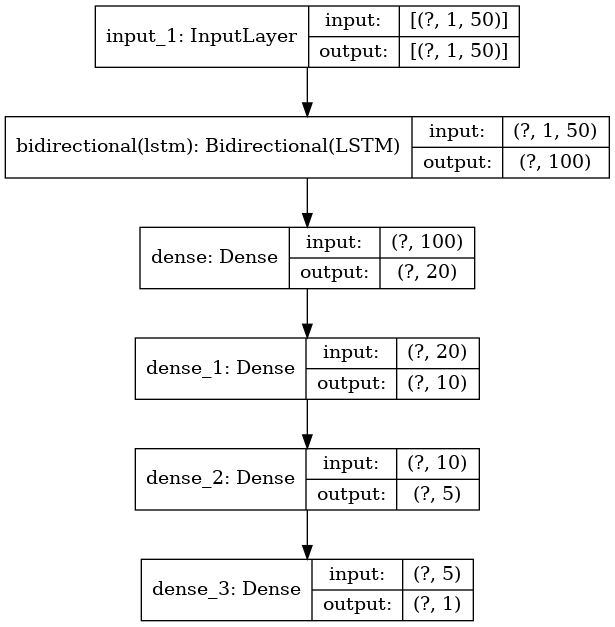

In [10]:
#reshape data to feed the net.
import tensorflow
hg_ic=list(hg_ic)
ng_ic=list(ng_ic)
xt=np.array(hg_ic+ng_ic)
perm=[i for i in range(xt.shape[0])]
np.random.shuffle(perm)
xt=xt.reshape(xt.shape[0],xt.shape[1],1)
yt = [1]*len(hg_ic)+[0]*len(ng_ic)


xt=np.array(xt)[perm]
xt=xt.reshape(xt.shape[0],xt.shape[2],xt.shape[1])
yt=np.array(yt)[perm]
#yt=yt.reshape(yt.shape[0], 1,1)


from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(xt, yt, test_size = 0.20, random_state = 42, shuffle = True)

#print(np.array(Xt_train)[:10,:3], np.array(Yt_train)[:10])


n_clusters=1
print(xt.shape)
print(Xt_train.shape)
inputs= tensorflow.keras.Input(shape=(1,xt.shape[2]))
lstm=[]
for i in range(n_clusters):
    #lstm.append(LSTM(xt.shape[1], dropout = 0.0,input_shape=(xt.shape[1],1), recurrent_dropout = 0.0)(inputs))
#kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)   
    lstm.append(Bidirectional(LSTM(N_genes//n_clusters, dropout = 0.0,input_shape=(xt.shape[1],1), recurrent_dropout = 0.0))(inputs))
#kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)   
#merge=concatenate([l for l in lstm])
#d=Dense(5,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))(inputs)
d1=Dense(20)(lstm[0])
d2=Dense(10)(d1)
d3=Dense(5)(d2)
f1=Dense(1, activation = 'sigmoid')(d3)

model = tensorflow.keras.Model(inputs = inputs , outputs = f1, name = "test")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
tensorflow.keras.utils.plot_model(model, show_shapes = True)


Whith a enough big dataset it should be always 100%, if the probability of the preferential chain is reasonable (>60) 



In [11]:
epochs = 9

history = model.fit(Xt_train, Yt_train, epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 50, shuffle = True)

Train on 76800 samples, validate on 19200 samples
Epoch 1/9
76800/76800 [==============================] - 18s 233us/sample - loss: 0.5045 - accuracy: 0.7370 - val_loss: 0.4145 - val_accuracy: 0.8085
Epoch 2/9
76800/76800 [==============================] - 12s 157us/sample - loss: 0.3853 - accuracy: 0.8255 - val_loss: 0.3569 - val_accuracy: 0.8421
Epoch 3/9
76800/76800 [==============================] - 12s 158us/sample - loss: 0.3600 - accuracy: 0.8392 - val_loss: 0.3620 - val_accuracy: 0.8387
Epoch 4/9
76800/76800 [==============================] - 12s 151us/sample - loss: 0.3465 - accuracy: 0.8467 - val_loss: 0.3678 - val_accuracy: 0.8348
Epoch 5/9
76800/76800 [==============================] - 12s 151us/sample - loss: 0.3344 - accuracy: 0.8529 - val_loss: 0.3660 - val_accuracy: 0.8376
Epoch 6/9
76800/76800 [==============================] - 12s 155us/sample - loss: 0.3255 - accuracy: 0.8566 - val_loss: 0.3442 - val_accuracy: 0.8476
Epoch 7/9
76800/76800 [===========================

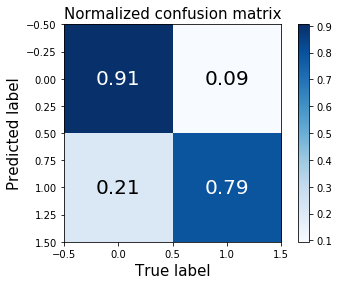

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

predicted_labels = model.predict(Xt_test)
cm = confusion_matrix(Yt_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]



plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 15)
plt.colorbar()
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()


yt=[]
xt=[]
hg_ic=[]
ng_ic=[]

## Long Range Correlations of nucleotides + Frequency of nucleotides -> Computation


In [13]:
#Must be perfomed on the pure chains, not divided in words.
print(humans.shape)
new_dict={'A':0, "C":1 , "G":2, "T":3}
print("START")
r=[i for i in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]]

couples_h=np.zeros((4,4,len(r)))
freqs_h=np.zeros(4)
couples_n=np.zeros((4,4, len(r)))
freqs_n=np.zeros(4)

for sentence in humans:
    for nuc in sentence:
        freqs_h[new_dict[nuc]]+=1
freqs_h=freqs_h/(humans.shape[0]*humans.shape[1])
print("Freqs H")
print(freqs_h)
fh_h=list(freqs_h)

print()

freqs_h=[[b for b in freqs_h]for a in freqs_h]
freqs_h=np.array(freqs_h).reshape((4,4))
print(freqs_h[:,0])

for sentence in neanderthals:
    for nuc in sentence:
        freqs_n[new_dict[nuc]]+=1
freqs_n=freqs_n/(neanderthals.shape[0]*neanderthals.shape[1])

print("Freqs_ N ")
print(freqs_n)
fn_n=list(freqs_n)

freqs_n=[[b for b in freqs_n]for a in freqs_n]
freqs_n=np.array(freqs_n).reshape(4,4)

print("Done P(x_i)")

for k in range(len(r)):
    for sentence in humans:
         for idx in range(len(sentence)-r[k]):
                couples_h[new_dict[sentence[idx]],new_dict[sentence[idx+r[k]]], k ]+=1            
    #couples_h[:,:,k]=couples_h[:,:,k]/(humans.shape[0]*(humans.shape[1]-r[k]))
    couples_h[:,:,k]=couples_h[:,:,k]/np.sum(couples_h[:,:,k],axis=1).reshape((4,1))
    print(np.sum(couples_h[:,:,k],axis=1))  

                
for k in range(len(r)):
    for sentence in neanderthals:
         for idx in range(len(sentence)-r[k]):
                couples_n[new_dict[sentence[idx]],new_dict[sentence[idx+r[k]]], k ]+=1
    #couples_n[:,:,k]=couples_n[:,:,k]/(neanderthals.shape[0]*(neanderthals.shape[1]-r[k]))
    couples_n[:,:,k]=couples_n[:,:,k]/np.sum(couples_n[:,:,k],axis=1).reshape((4,1))
    print(np.sum(couples_n[:,:,k], axis =1))                      
print("Done P(x_i|x_j)")
#for i in range(len(r)):
#    print("Check")
#    print(couples_n[:,:,i])

#compute correlations
    #sum i sum j couples[i,j]-

Cr_h=np.zeros(len(r))
Cr_n=np.zeros(len(r))
for k in range(len(r)):
 
    print(np.sum(couples_h[:,:,k]-freqs_h))
    Cr_h[k]=np.sum((couples_h[:,:,k]-freqs_h)**2)
    Cr_n[k]=np.sum((couples_n[:,:,k]-freqs_n)**2)

print(freqs_h.shape)

(60000, 1500)
START
Freqs H
[0.24630226 0.26913521 0.2240267  0.26053583]

[0.24630226 0.24630226 0.24630226 0.24630226]
Freqs_ N 
[0.24634962 0.26914169 0.22402348 0.26048521]
Done P(x_i)
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
Done P(x_i|x_j)
-2.7755575615628914e-17
5.551115123125783e-17
-2.7755575615628914e-17
-8.326672684688674e-17
2.7755575615628914e-17
-5.551115123125783e-17
2.7755575615628914e-17
0.0
-5.551115123125783e-17
8.326672684688674e-17
2.7755575615628914e-17
5

## Correlations Plot

,0,1,2
0,5.0,0.074297,0.074706
1,10.0,0.046075,0.046026
2,15.0,0.039633,0.039509
3,20.0,0.052039,0.052246
4,25.0,0.025967,0.026240
5,30.0,0.027038,0.027196
6,35.0,0.028599,0.028370
7,40.0,0.058351,0.058520
8,45.0,0.038463,0.038262
9,50.0,0.052088,0.051631


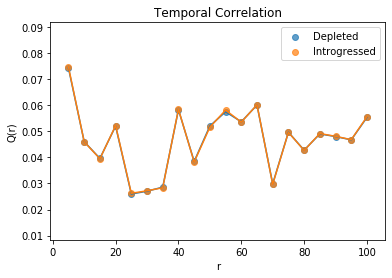

In [14]:
# Dont see any correlation..
import matplotlib.pyplot as plt
#plt.xscale=('linear')

corrs_hn=np.array([r,Cr_h,Cr_n])
corrs_hn = corrs_hn.reshape((3,len(r))).T
corrs_hn[:,-2:]=np.sqrt(corrs_hn[:,-2:])
display(pd.DataFrame(corrs_hn))
#np.savetxt(corrs_hnm)
#np.save_txt(rCr)
plt.title("Temporal Correlation")
plt.scatter(corrs_hn[:,0],corrs_hn[:,1], label="Depleted", alpha =0.7)
plt.scatter(corrs_hn[:,0],corrs_hn[:,2], label="Introgressed", alpha =0.7)
plt.plot(corrs_hn[:,0],corrs_hn[:,1])
plt.plot(corrs_hn[:,0],corrs_hn[:,2])
#plt.ylim(0,+0.025)
plt.ylabel("Q(r)")
plt.xlabel("r")
plt.legend()
plt.savefig("Temporal_corr_V31")
#plt.xscale=('log')
plt.show()




## Frequency of Nucleotides Plot

[[0.24630226 0.26913521 0.2240267  0.26053583]
 [0.24630226 0.26913521 0.2240267  0.26053583]
 [0.24630226 0.26913521 0.2240267  0.26053583]
 [0.24630226 0.26913521 0.2240267  0.26053583]]


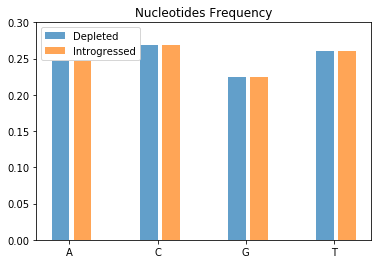

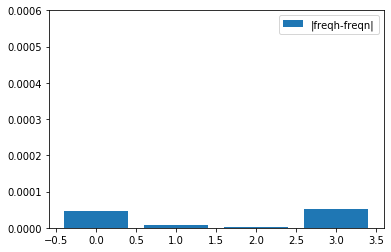

In [15]:
print(freqs_h)
plt.title("Nucleotides Frequency")
plt.bar(range(4),fh_h,0.2, label = "Depleted", alpha =0.7)
plt.bar(np.array(range(4))+0.25,fn_n,0.2, label= "Introgressed", color ="C1", alpha =0.7)
plt.xticks([0.1+i for i in range(4)], ['A','C','G','T'])
plt.ylim(0,0.3)
plt.legend()
plt.savefig("Nucleotides_f_V3")
plt.show()

plt.bar(range(4),abs(np.array(fn_n)-np.array(fh_h)), label= "|freqh-freqn|")
plt.ylim(0,+0.0006)
plt.legend()
plt.show()

## Check the words frequency for DNA

In [16]:
DNA_length= sentence_length*N_people
#make words strings.
h_DNA = np.array([[''.join(h_DNA[i,j,:]) for i in range(h_DNA.shape[0]) ]for 
                  j in range(h_DNA.shape[1])])
#make words strings.
n_DNA = np.array([[''.join(n_DNA[i,j,:]) for i in range(n_DNA.shape[0]) ]for 
                  j in range(n_DNA.shape[1])])

print(h_DNA.shape)

(60000, 300)


array(['TCACT', 'TCGAT', 'CGCAC', ..., 'CACAG', 'GAGGC', 'CGTAG'],
      dtype='<U5')

here
there
20


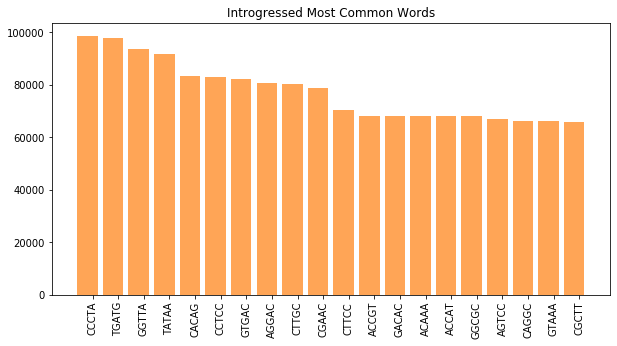

here
there
20


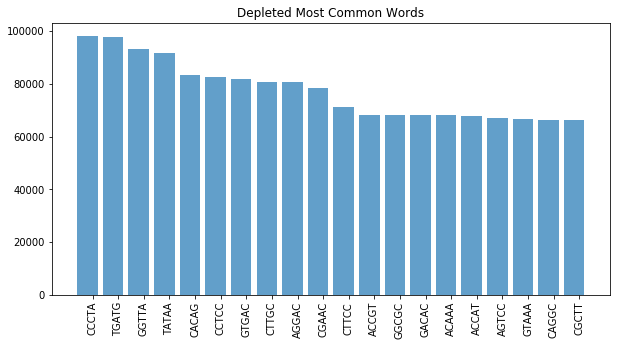

In [17]:


h_DNA_check= h_DNA.reshape(DNA_length//word_length)
n_DNA_check= n_DNA.reshape(DNA_length//word_length)
display(h_DNA_check)
h_DNA_check1=[]
n_DNA_check1=[]



from collections import Counter
import matplotlib.pyplot as  plt
##NEANDERTHAL
print("here")
counts_n=dict(Counter(n_DNA_check).most_common(20))
print("there")
labels_n, values_n = zip(*counts_n.items())

#sort
indsort_n = np.argsort(values_n)[::-1]
plt.figure(figsize=(10,5)) 
#re_arrange
plt.title("Introgressed Most Common Words")
labels_n= np.array(labels_n)[indsort_n]
values_n= np.array(values_n)[indsort_n]
indexes_n = np.arange(len(values_n))
bar_width=0.2
plt.bar(indexes_n, values_n, alpha = 0.7, color= "C1")
plt.xticks(indexes_n+bar_width,labels_n, rotation= 90)
print(len(counts_n))
plt.savefig("Introgrmw_V3", bbox_inches='tight')
plt.show()



##HUMAN
print("here")
counts_h=dict(Counter(h_DNA_check).most_common(20))
print("there")
labels_h, values_h = zip(*counts_h.items())

#sort
indsort_h = np.argsort(values_h)[::-1]
plt.figure(figsize=(10,5)) 
#re_arrange
labels_h= np.array(labels_h)[indsort_h]
values_h= np.array(values_h)[indsort_h]
indexes_h = np.arange(len(values_h))
bar_width=0.2
plt.bar(indexes_h, values_h, alpha = 0.7)
plt.title("Depleted Most Common Words")
plt.xticks(indexes_h+bar_width,labels_h, rotation= 90)
print(len(counts_h))
plt.savefig("Depletedmw_V3", bbox_inches='tight')
plt.show()




## Prepare Data for NN

Create Y, divide in words + tokenizer on X

In [18]:
h_DNA_NN=[' '.join(h_DNA[i,:]) for i in range(h_DNA.shape[0])]
n_DNA_NN=[' '.join(n_DNA[i,:]) for i in range(n_DNA.shape[0])]

DNA_NN = h_DNA_NN+n_DNA_NN
Y = [1]*len(h_DNA_NN)+[0]*len(n_DNA_NN)



tokenizer.fit_on_texts(DNA_NN)

encoded_docs = tokenizer.texts_to_sequences(DNA_NN)

#max_length = max([len(s.split()) for s in DNA_NN])
max_length = 200
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')


from sklearn.model_selection import train_test_split
#X=X.reshape(X.shape[0],X.shape[1],1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42, shuffle = True)

print(X_train.shape)
print(len(Y_train))
vocab_size = len(tokenizer.word_index) + 1
print(max_length)
print(vocab_size)



(96000, 200)
96000
200
1025


In [19]:
"""from tf.keras.preprocessing.text import Tokenizer
from tf.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
#test 2
Y = [1]*len(h_DNA)+[0]*len(n_DNA)
print(len(h_DNA))
print(len(Y))
X = list(h_DNA)+list(n_DNA)
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20,  shuffle = True)


X_train=np.array(X_train)
X_test=np.array(X_test)
Y_train = np.array(Y_train)

#X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],1))
#X_test=X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(Y_train.shape)"""

'from tf.keras.preprocessing.text import Tokenizer\nfrom tf.keras.preprocessing.sequence import pad_sequences\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.feature_extraction.text import TfidfTransformer\nfrom sklearn.model_selection import train_test_split\n#test 2\nY = [1]*len(h_DNA)+[0]*len(n_DNA)\nprint(len(h_DNA))\nprint(len(Y))\nX = list(h_DNA)+list(n_DNA)\nprint(len(X))\nX_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20,  shuffle = True)\n\n\nX_train=np.array(X_train)\nX_test=np.array(X_test)\nY_train = np.array(Y_train)\n\n#X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],1))\n#X_test=X_test.reshape((X_test.shape[0],X_test.shape[1],1))\n\nprint(X_train.shape)\nprint(Y_train.shape)'

## Let's build an LSTM NN

In [20]:
"""    from tf.keras.models import Sequential
    from tf.keras.callbacks import ModelCheckpoint
    from tf.keras.optimizers import SGD, Adam, Adadelta, RMSprop
    from tf.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
    from tf.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional
    from tf.keras.layers.convolutional_recurrent import ConvLSTM2D
    from tf.keras import regularizers

    model = Sequential()
    model.add(Embedding(vocab_size, 32, input_length = max_length, dropout = 0.2))
    #model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))  #this sucks
    model.add(LSTM(10, dropout = 0.2, recurrent_dropout = 0.2))  #totally killing it
    #model.add(Conv1D(10, dropout = 0.2, recurrent_dropout = 0.2)) 

    model.add(Dense(5,
                    kernel_regularizer=regularizers.l2(0.01),
                    activity_regularizer=regularizers.l1(0.01)))
    model.add(Dense(1, activation = 'sigmoid'))


    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
    checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                                 save_best_only = True, mode = 'max')
    print(model.summary())"""

'    from tf.keras.models import Sequential\n    from tf.keras.callbacks import ModelCheckpoint\n    from tf.keras.optimizers import SGD, Adam, Adadelta, RMSprop\n    from tf.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout\n    from tf.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional\n    from tf.keras.layers.convolutional_recurrent import ConvLSTM2D\n    from tf.keras import regularizers\n\n    model = Sequential()\n    model.add(Embedding(vocab_size, 32, input_length = max_length, dropout = 0.2))\n    #model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))  #this sucks\n    model.add(LSTM(10, dropout = 0.2, recurrent_dropout = 0.2))  #totally killing it\n    #model.add(Conv1D(10, dropout = 0.2, recurrent_dropout = 0.2)) \n\n    model.add(Dense(5,\n                    kernel_regularizer=regularizers.l2(0.01),\n                    activity_regularizer=regularizers.l1(0.01)))\n    model.add(Dense(1, activation = \'sig

## NN

In [21]:
"""print(X_train.shape)
print(max_length)

n_clusters=1
#inputs= keras.Input(shape=(max_length,1))
inputs= tensorflow.keras.Input(shape=(max_length))
emb=Embedding(vocab_size, 32, input_length = max_length)(inputs)
f=Flatten()(emb)
#merge=concatenate([l for l in lstm])
d=Dense( 50)(f)
#d=Dense(10,kernel_regularizer=regularizers.l2(0.02))(lstm[0])
d1=Dense(20)(d)
d1=Dense(10)(d)
f=Dense(1, activation = 'sigmoid')(d1)

model = tensorflow.keras.Model(inputs = inputs , outputs = f, name = "test")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

from keras.models import load_model


#model.save('model_P'+str(1-3*old_det)+'.h5')  



# returns a compiled model
# identical to the previous one
#model = load_model('model_P'+str(1-3*old_det)+'.h5')
#model.load_weights('model_weights_P.h5')


#old_det = det

tensorflow.keras.utils.plot_model(model, show_shapes = True)"""

'print(X_train.shape)\nprint(max_length)\n\nn_clusters=1\n#inputs= keras.Input(shape=(max_length,1))\ninputs= tensorflow.keras.Input(shape=(max_length))\nemb=Embedding(vocab_size, 32, input_length = max_length)(inputs)\nf=Flatten()(emb)\n#merge=concatenate([l for l in lstm])\nd=Dense( 50)(f)\n#d=Dense(10,kernel_regularizer=regularizers.l2(0.02))(lstm[0])\nd1=Dense(20)(d)\nd1=Dense(10)(d)\nf=Dense(1, activation = \'sigmoid\')(d1)\n\nmodel = tensorflow.keras.Model(inputs = inputs , outputs = f, name = "test")\nmodel.compile(loss = \'binary_crossentropy\', optimizer = \'rmsprop\', metrics = [\'accuracy\'])\n\nfrom keras.models import load_model\n\n\n#model.save(\'model_P\'+str(1-3*old_det)+\'.h5\')  \n\n\n\n# returns a compiled model\n# identical to the previous one\n#model = load_model(\'model_P\'+str(1-3*old_det)+\'.h5\')\n#model.load_weights(\'model_weights_P.h5\')\n\n\n#old_det = det\n\ntensorflow.keras.utils.plot_model(model, show_shapes = True)'

## CNN

(96000, 200)
200


Using TensorFlow backend.


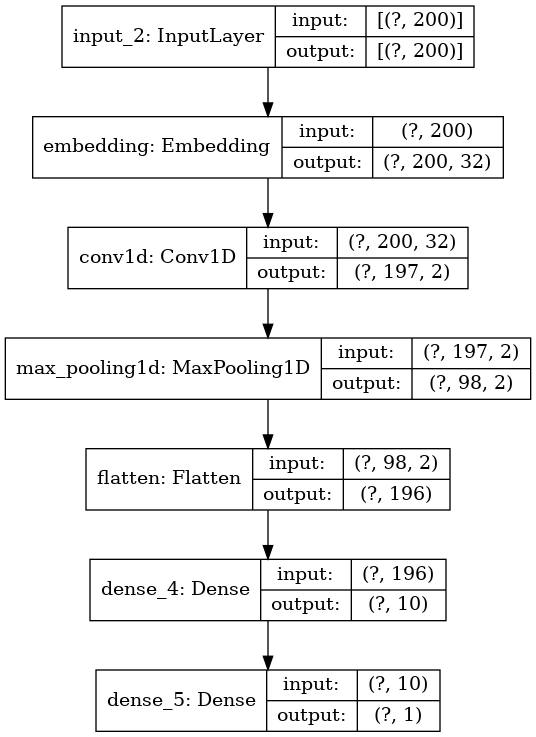

In [22]:
print(X_train.shape)
print(max_length)

n_clusters=1
#inputs= keras.Input(shape=(max_length,1))
inputs= tensorflow.keras.Input(shape=(200,))
emb=Embedding(vocab_size, 32, input_length = max_length)(inputs)
lstm=[]
conv1 = Conv1D(filters=2,
               kernel_size=4,
               strides=1,
               activation='relu')(emb)
pool1 = MaxPooling1D(pool_size=2)(conv1)
#for i in range(n_clusters):
    #lstm.append(Bidirectional(LSTM(N_genes, dropout=0.1))(emb))
#    lstm.append(Bidirectional(LSTM(N_genes))(emb))
f=Flatten()(pool1)
#merge=concatenate([l for l in lstm])
d=Dense(10 )(f)
#d=Dense(10,kernel_regularizer=regularizers.l2(0.02))(lstm[0])
#d1=Dense(5)(d)
f=Dense(1, activation = 'sigmoid')(d)

model = tensorflow.keras.Model(inputs = inputs , outputs = f, name = "test")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

from keras.models import load_model


#model.save('model_P'+str(1-3*old_det)+'.h5')  



# returns a compiled model
# identical to the previous one
#model = load_model('model_P'+str(1-3*old_det)+'.h5')
#model.load_weights('model_weights_P.h5')


#old_det = det

tensorflow.keras.utils.plot_model(model, show_shapes = True)

In [23]:

#X_train= X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
shuffle = list(range(len(Y_train)))

X_train = np.array(X_train)
Y_train=np.array(Y_train)

np.random.shuffle(shuffle)
X_train = np.array(X_train[shuffle])
Y_train=np.array(Y_train[shuffle])
history = model.fit(X_train, Y_train, epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 50, shuffle = True)


Train on 76800 samples, validate on 19200 samples
Epoch 1/9
76800/76800 [==============================] - 11s 148us/sample - loss: 0.6859 - accuracy: 0.5479 - val_loss: 0.6743 - val_accuracy: 0.5927
Epoch 2/9
76800/76800 [==============================] - 10s 132us/sample - loss: 0.6654 - accuracy: 0.6007 - val_loss: 0.6655 - val_accuracy: 0.5978
Epoch 3/9
76800/76800 [==============================] - 10s 127us/sample - loss: 0.6471 - accuracy: 0.6246 - val_loss: 0.6619 - val_accuracy: 0.6087
Epoch 4/9
76800/76800 [==============================] - 11s 138us/sample - loss: 0.6364 - accuracy: 0.6376 - val_loss: 0.6710 - val_accuracy: 0.5979
Epoch 5/9
76800/76800 [==============================] - 11s 144us/sample - loss: 0.6301 - accuracy: 0.6428 - val_loss: 0.6733 - val_accuracy: 0.6006
Epoch 6/9
76800/76800 [==============================] - 10s 133us/sample - loss: 0.6249 - accuracy: 0.6511 - val_loss: 0.6718 - val_accuracy: 0.5986
Epoch 7/9
76800/76800 [===========================

(96000, 200)
200


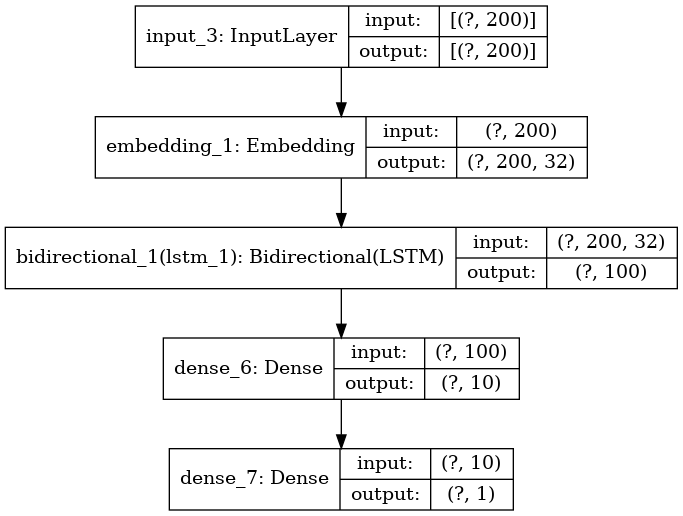

In [24]:
print(X_train.shape)
print(max_length)

n_clusters=1
#inputs= keras.Input(shape=(max_length,1))
inputs= tensorflow.keras.Input(shape=(200,))
emb=Embedding(vocab_size, 32, input_length = max_length)(inputs)
lstm=[]
conv1 = Conv1D(filters=2,
               kernel_size=4,
               strides=1,
               activation='relu')(emb)
pool1 = MaxPooling1D(pool_size=2)(conv1)
for i in range(n_clusters):
    #lstm.append(Bidirectional(LSTM(N_genes, dropout=0.1))(emb))
    lstm.append(Bidirectional(LSTM(N_genes))(emb))

#merge=concatenate([l for l in lstm])
d=Dense(10 )(lstm[0])
#d=Dense(10,kernel_regularizer=regularizers.l2(0.02))(lstm[0])
#d1=Dense(5)(d)
f=Dense(1, activation = 'sigmoid')(d)

model = tensorflow.keras.Model(inputs = inputs , outputs = f, name = "test")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

from keras.models import load_model


#model.save('model_P'+str(1-3*old_det)+'.h5')  



# returns a compiled model
# identical to the previous one
#model = load_model('model_P'+str(1-3*old_det)+'.h5')
#---model.load_weights('model_weights_P.h5')


#old_det = det

tensorflow.keras.utils.plot_model(model, show_shapes = True)


#Manopole
#decide the percentage of geneDNA in a sentence.
pc_genes=0.7
#How many genes?
N_genes= 30
#Choose genes to correlate
#How many?
avg_dimension_of_correlation_clusters=10
b=0.5 #how different are different genes ? max 0.5
fraction_of_mutations_per_gene=1#percentage of random mutations in gene variants
variants=4 #how may variants?
det=0.0  #how much deterministic is the markov chain 0 MAX 0.25 Min  shuffle(prob(det det det 1-3*det))
forward_mc = False#do you want forward markov chain?
N_people= 3000
sentence_length= 999 #HOW LONG A SENTENCE in letters
word_length=3 #HOW LONG A WORD in letters

same = True
with embedding -> WORKSS!! Thus no random..


worked with det = 0.05

30 it 80% acc

det = 0.01
30 it   67%

In [25]:

#X_train= X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
shuffle = list(range(len(Y_train)))

X_train = np.array(X_train)
Y_train=np.array(Y_train)

np.random.shuffle(shuffle)
X_train = np.array(X_train[shuffle])
Y_train=np.array(Y_train[shuffle])
history = model.fit(X_train, Y_train, epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 50, shuffle = True)


Train on 76800 samples, validate on 19200 samples
Epoch 1/9
76800/76800 [==============================] - 86s 1ms/sample - loss: 0.6934 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4962
Epoch 2/9
76800/76800 [==============================] - 72s 932us/sample - loss: 0.6925 - accuracy: 0.5139 - val_loss: 0.6937 - val_accuracy: 0.5077
Epoch 3/9
76800/76800 [==============================] - 62s 808us/sample - loss: 0.6885 - accuracy: 0.5382 - val_loss: 0.6939 - val_accuracy: 0.5058
Epoch 4/9
76800/76800 [==============================] - 62s 807us/sample - loss: 0.6861 - accuracy: 0.5472 - val_loss: 0.6984 - val_accuracy: 0.5043
Epoch 5/9
76800/76800 [==============================] - 62s 808us/sample - loss: 0.6827 - accuracy: 0.5568 - val_loss: 0.6938 - val_accuracy: 0.5361
Epoch 6/9
76800/76800 [==============================] - 66s 859us/sample - loss: 0.6671 - accuracy: 0.5936 - val_loss: 0.6774 - val_accuracy: 0.5910
Epoch 7/9
76800/76800 [=============================

In [26]:
# Save the weights
model.save_weights('model_weights_P.h5')


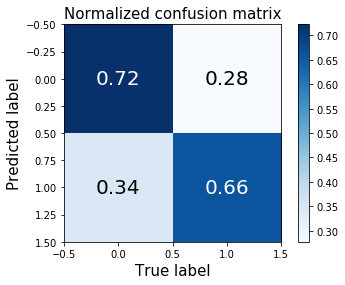

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

predicted_labels = model.predict(X_test)
cm = confusion_matrix(Y_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]



plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 15)
plt.colorbar()
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()